In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from sk_models import setup_pls_models_slim

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#setup input and output formats, load data

file_name = "mango_513_1050.csv"
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp','FruitID']#
output_cols = ['DM']
n_comps = [i for i in range(1,101)]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/2.01")
model_path = Path('D:/workspace/lazydeep/experiments/2.00/')
data_file = data_path / file_name

log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)/"models"

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)


D:\workspace\lazydeep\experiments\2.01\mango_513_1050


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)
n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
eval = MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 190)


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [4]:
n_models = 100
model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/name/"_model") for name in model_names}
#for each model, load state
print(f"Loaded {len(deep_models)} models")
#print(deep_models)
for name in model_names:
    sub_path = log_dir / name
    if not sub_path.exists():
        sub_path.mkdir()

Loaded 100 models


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")


In [6]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = None#Preprocess_Std()
eval = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True)
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/name/f"_fold_{fold}")
load_fun_build = lambda name,model : model.load_state(model_dir/name/f"_final")

In [7]:
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=True,update=False)
deep_scores, deep_preds, _ , _, _ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv)
deep_scores_final, deep_preds_final, _ ,_, _ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build)

all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})

all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Tested (test) on 1949 instances with mean losses of: random_0:4.6742,random_1:4.9521,random_2:5.1038,random_3:1.6768,random_4:6.0408,random_5:0.6398,random_6:5.4773,random_7:70.3993,random_8:5.2345,random_9:3.0102,random_10:1.5758,random_11:2.8468,random_12:1.195,random_13:2.7394,random_14:6.3428,random_15:3.8803,random_16:1.2451,random_17:2.7659,random_18:1.2486,random_19:4.1118,random_20:4.3596,random_21:6.0672,random_22:10.9483,random_23:2.9532,random_24:6.0758,random_25:3.6459,random_26:0.6934,random_27:5.3205,random_28:6.6927,random_29:3.8216,random_30:0.8512,random_31:2.5595,random_32:5.2996,random_33:268.0037,random_34:2.7018,random_35:3.4595,random_36:0.8048,random_37:4.134,random_38:4.2124,random_39:5.3565,random_40:0.6489,random_41:4.3224,random_42:0.6699,random_43:4.7179,random_44:6.7839,random_45:269.0776,random_46:4.6872,r

In [8]:
for deep_name,deep_model in deep_models.items():
    logging.getLogger().info(f"Running model {deep_name}")
    temp_dict = {deep_name:deep_model}

    lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_slim(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
    lwr_scores, lwr_preds, _ , _, _= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv)
    lwr_scores_final, lwr_preds_final, _ , _, _= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build)

    #scores
    for k,v in ut.flip_dicts(lwr_scores).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores.append({**dict1,**v})

    for k,v in ut.flip_dicts(lwr_scores_final).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores_final.append({**dict1,**v})

    lwr_preds['deep'] = deep_preds[deep_name]
    lwr_preds_final['deep'] = deep_preds_final[deep_name]

    lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
    lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

    #preds
    # todo save predictions - appending solns
    plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)



Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6502,lwr_k=20:3.5438,lwr_k=50:3.798,lwr_k=100:3.8895,lwr_k=200:3.9173,lwr_k=500:3.9454,lwr_k=1000:3.9641'
Tested (test) on 1949 instances with mean losses of: lr:3.6118,lwr_k=20:3.9947,lwr_k=50:4.004,lwr_k=100:3.9969,lwr_k=200:3.9542,lwr_k=500:3.9595,lwr_k=1000:3.9627'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6953,lwr_k=20:3.299,lwr_k=50:3.4635,lwr_k=100:3.5315,lwr_k=200:3.5918,lwr_k=500:3.6623,lwr_k=1000:3.6958'
Tested (test) on 1949 instances with mean losses of: lr:3.8403,lwr_k=20:3.6831,lwr_k=50:3.7075,lwr_k=100:3.7314,lwr_k=200:3.7567,lwr_k=500:3.8074,lwr_k=1000:3.8169'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9302,lwr_k=20:3.3972,lwr_k=50:3.6034,lwr_k=100:3.6907,lwr_k=200:3.7274,lwr_k=500:3.7694,lwr_k=1000:3.7962'
Tested (test) on 1949 instances with mean losses of: lr:3.8946,lwr_k=20:3.7669,lwr_k=50:3.8294,lwr_k=100:3.8286,lwr_k=200:3.8267,lwr_k=500:3.8401,lwr_k=1000:3.8325'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9109,lwr_k=20:3.7251,lwr_k=50:3.9189,lwr_k=100:3.9655,lwr_k=200:3.996,lwr_k=500:4.0277,lwr_k=1000:4.0228'
Tested (test) on 1949 instances with mean losses of: lr:4.0011,lwr_k=20:4.3996,lwr_k=50:4.2533,lwr_k=100:4.2023,lwr_k=200:4.1975,lwr_k=500:4.183,lwr_k=1000:4.1732'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_2'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.4861,lwr_k=20:2.3289,lwr_k=50:3.0786,lwr_k=100:3.5007,lwr_k=200:3.7431,lwr_k=500:3.9553,lwr_k=1000:4.0999'
Tested (test) on 1949 instances with mean losses of: lr:4.4171,lwr_k=20:4.0132,lwr_k=50:3.8221,lwr_k=100:3.8614,lwr_k=200:3.9786,lwr_k=500:4.0869,lwr_k=1000:4.1948'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.7859,lwr_k=20:2.6326,lwr_k=50:3.4492,lwr_k=100:3.809,lwr_k=200:4.0999,lwr_k=500:4.2581,lwr_k=1000:4.4133'
Tested (test) on 1949 instances with mean losses of: lr:4.9669,lwr_k=20:4.325,lwr_k=50:4.2962,lwr_k=100:4.3184,lwr_k=200:4.3986,lwr_k=500:4.4749,lwr_k=1000:4.5839'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_3'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.3305,lwr_k=20:0.4992,lwr_k=50:0.7829,lwr_k=100:0.9324,lwr_k=200:1.0481,lwr_k=500:1.1328,lwr_k=1000:1.1929'
Tested (test) on 1949 instances with mean losses of: lr:1.2145,lwr_k=20:0.9509,lwr_k=50:0.9417,lwr_k=100:0.9463,lwr_k=200:0.9754,lwr_k=500:1.0459,lwr_k=1000:1.0944'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.4109,lwr_k=20:0.7191,lwr_k=50:1.0556,lwr_k=100:1.2214,lwr_k=200:1.3555,lwr_k=500:1.5255,lwr_k=1000:1.6782'
Tested (test) on 1949 instances with mean losses of: lr:2.3479,lwr_k=20:1.4137,lwr_k=50:1.412,lwr_k=100:1.4077,lwr_k=200:1.4335,lwr_k=500:1.5368,lwr_k=1000:1.6622'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9489,lwr_k=20:3.9905,lwr_k=50:4.3284,lwr_k=100:4.3861,lwr_k=200:4.328,lwr_k=500:4.2977,lwr_k=1000:4.3162'
Tested (test) on 1949 instances with mean losses of: lr:3.8945,lwr_k=20:4.4796,lwr_k=50:4.5172,lwr_k=100:4.4962,lwr_k=200:4.3923,lwr_k=500:4.3033,lwr_k=1000:4.2994'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.64,lwr_k=20:3.2305,lwr_k=50:3.4616,lwr_k=100:3.5452,lwr_k=200:3.5883,lwr_k=500:3.6234,lwr_k=1000:3.6544'
Tested (test) on 1949 instances with mean losses of: lr:3.7827,lwr_k=20:3.7813,lwr_k=50:3.7334,lwr_k=100:3.7068,lwr_k=200:3.7173,lwr_k=500:3.7444,lwr_k=1000:3.7613'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6279,lwr_k=20:0.5529,lwr_k=50:0.583,lwr_k=100:0.5986,lwr_k=200:0.6079,lwr_k=500:0.615,lwr_k=1000:0.6195'
Tested (test) on 1949 instances with mean losses of: lr:0.5995,lwr_k=20:0.6223,lwr_k=50:0.5987,lwr_k=100:0.5996,lwr_k=200:0.6016,lwr_k=500:0.5978,lwr_k=1000:0.6003'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.618,lwr_k=20:0.42,lwr_k=50:0.5093,lwr_k=100:0.554,lwr_k=200:0.5816,lwr_k=500:0.6033,lwr_k=1000:0.6122'
Tested (test) on 1949 instances with mean losses of: lr:0.6232,lwr_k=20:0.5774,lwr_k=50:0.6009,lwr_k=100:0.6037,lwr_k=200:0.6083,lwr_k=500:0.6139,lwr_k=1000:0.6183'
-----------------------------------Fold 2 - Train 5846 - Val 1948 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_6'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.6549,lwr_k=20:4.5022,lwr_k=50:4.8311,lwr_k=100:4.8595,lwr_k=200:4.8109,lwr_k=500:4.7008,lwr_k=1000:4.6339'
Tested (test) on 1949 instances with mean losses of: lr:5.531,lwr_k=20:5.1956,lwr_k=50:5.1004,lwr_k=100:5.0122,lwr_k=200:4.8853,lwr_k=500:4.721,lwr_k=1000:4.6282'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.9143,lwr_k=20:3.0682,lwr_k=50:3.8524,lwr_k=100:4.2182,lwr_k=200:4.3896,lwr_k=500:4.535,lwr_k=1000:4.5711'
Tested (test) on 1949 instances with mean losses of: lr:5.0416,lwr_k=20:4.7743,lwr_k=50:4.7097,lwr_k=100:4.6539,lwr_k=200:4.7636,lwr_k=500:4.7898,lwr_k=1000:4.7927'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_7'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.3636,lwr_k=20:3.404,lwr_k=50:3.9879,lwr_k=100:4.4211,lwr_k=200:13.8943,lwr_k=500:45.9534,lwr_k=1000:5.7647'
Tested (test) on 1949 instances with mean losses of: lr:5.394,lwr_k=20:5.1149,lwr_k=50:4.8351,lwr_k=100:4.8172,lwr_k=200:5.277,lwr_k=500:5.465,lwr_k=1000:5.3372'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6452,lwr_k=20:5.251,lwr_k=50:5.491,lwr_k=100:5.4802,lwr_k=200:5.422,lwr_k=500:5.2814,lwr_k=1000:5.1335'
Tested (test) on 1949 instances with mean losses of: lr:4.7593,lwr_k=20:6.044,lwr_k=50:5.8604,lwr_k=100:5.7292,lwr_k=200:5.6031,lwr_k=500:5.4395,lwr_k=1000:5.2683'
-----------------------------------Fold 2 - Train 5846 - Val 1948 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.9147,lwr_k=20:4.5075,lwr_k=50:4.7094,lwr_k=100:4.7887,lwr_k=200:4.8301,lwr_k=500:4.86,lwr_k=1000:4.866'
Tested (test) on 1949 instances with mean losses of: lr:4.8512,lwr_k=20:5.066,lwr_k=50:4.9457,lwr_k=100:4.9206,lwr_k=200:4.9014,lwr_k=500:4.8757,lwr_k=1000:4.8642'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.9895,lwr_k=20:4.0767,lwr_k=50:4.3543,lwr_k=100:4.5331,lwr_k=200:4.6949,lwr_k=500:4.7427,lwr_k=1000:4.7739'
Tested (test) on 1949 instances with mean losses of: lr:5.1238,lwr_k=20:4.8595,lwr_k=50:4.8664,lwr_k=100:4.854,lwr_k=200:4.8951,lwr_k=500:4.919,lwr_k=1000:4.9326'
-----------------------------------Fold 2 - Train 5846 - Val 1948 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.848,lwr_k=20:0.1143,lwr_k=50:0.435,lwr_k=100:0.8958,lwr_k=200:1.4089,lwr_k=500:1.967,lwr_k=1000:2.273'
Tested (test) on 1949 instances with mean losses of: lr:2.8753,lwr_k=20:2.0118,lwr_k=50:1.9744,lwr_k=100:1.942,lwr_k=200:2.069,lwr_k=500:2.3171,lwr_k=1000:2.457'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.0038,lwr_k=20:0.1641,lwr_k=50:0.4415,lwr_k=100:0.6923,lwr_k=200:0.9768,lwr_k=500:1.2826,lwr_k=1000:1.5224'
Tested (test) on 1949 instances with mean losses of: lr:1.9583,lwr_k=20:1.4656,lwr_k=50:1.2642,lwr_k=100:1.2103,lwr_k=200:1.3086,lwr_k=500:1.4321,lwr_k=1000:1.5623'
-----------------------------------Fold 2 - Train 5846 - Val 1948 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4854,lwr_k=20:0.6193,lwr_k=50:0.9431,lwr_k=100:1.0764,lwr_k=200:1.1793,lwr_k=500:1.2916,lwr_k=1000:1.3613'
Tested (test) on 1949 instances with mean losses of: lr:1.3524,lwr_k=20:1.1267,lwr_k=50:1.0961,lwr_k=100:1.1155,lwr_k=200:1.1327,lwr_k=500:1.2011,lwr_k=1000:1.2518'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.0397,lwr_k=20:1.0423,lwr_k=50:1.4251,lwr_k=100:1.5416,lwr_k=200:1.6383,lwr_k=500:1.7365,lwr_k=1000:1.8294'
Tested (test) on 1949 instances with mean losses of: lr:2.1002,lwr_k=20:1.6668,lwr_k=50:1.6943,lwr_k=100:1.742,lwr_k=200:1.7485,lwr_k=500:1.795,lwr_k=1000:1.8667'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_11'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.5851,lwr_k=20:0.9782,lwr_k=50:1.3898,lwr_k=100:1.6651,lwr_k=200:1.9058,lwr_k=500:2.1716,lwr_k=1000:2.3305'
Tested (test) on 1949 instances with mean losses of: lr:2.5301,lwr_k=20:2.1935,lwr_k=50:2.3139,lwr_k=100:2.2964,lwr_k=200:2.3278,lwr_k=500:2.3725,lwr_k=1000:2.4019'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.4898,lwr_k=20:2.2354,lwr_k=50:2.4085,lwr_k=100:2.4656,lwr_k=200:2.5008,lwr_k=500:2.5264,lwr_k=1000:2.5424'
Tested (test) on 1949 instances with mean losses of: lr:2.499,lwr_k=20:2.5641,lwr_k=50:2.5163,lwr_k=100:2.517,lwr_k=200:2.5052,lwr_k=500:2.4738,lwr_k=1000:2.4928'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_12'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0525,lwr_k=20:0.9457,lwr_k=50:0.9657,lwr_k=100:0.9719,lwr_k=200:0.9774,lwr_k=500:0.9787,lwr_k=1000:0.9812'
Tested (test) on 1949 instances with mean losses of: lr:1.0725,lwr_k=20:1.0188,lwr_k=50:0.9988,lwr_k=100:0.9903,lwr_k=200:0.9888,lwr_k=500:0.9903,lwr_k=1000:0.9939'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.989,lwr_k=20:0.8812,lwr_k=50:0.9005,lwr_k=100:0.9074,lwr_k=200:0.9098,lwr_k=500:0.9126,lwr_k=1000:0.9147'
Tested (test) on 1949 instances with mean losses of: lr:1.0117,lwr_k=20:0.9394,lwr_k=50:0.9296,lwr_k=100:0.9385,lwr_k=200:0.9239,lwr_k=500:0.9225,lwr_k=1000:0.9242'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_13'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.3068,lwr_k=20:1.3877,lwr_k=50:1.6721,lwr_k=100:1.8422,lwr_k=200:1.9554,lwr_k=500:2.0735,lwr_k=1000:2.1428'
Tested (test) on 1949 instances with mean losses of: lr:2.1402,lwr_k=20:1.8597,lwr_k=50:1.8679,lwr_k=100:1.9063,lwr_k=200:1.9112,lwr_k=500:1.942,lwr_k=1000:2.0015'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.5402,lwr_k=20:1.3611,lwr_k=50:1.7359,lwr_k=100:1.9411,lwr_k=200:2.0809,lwr_k=500:2.2452,lwr_k=1000:2.3167'
Tested (test) on 1949 instances with mean losses of: lr:2.5549,lwr_k=20:2.0755,lwr_k=50:2.0875,lwr_k=100:2.1796,lwr_k=200:2.2565,lwr_k=500:2.3147,lwr_k=1000:2.3515'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9936,lwr_k=20:5.995,lwr_k=50:5.994,lwr_k=100:6.0111,lwr_k=200:6.0357,lwr_k=500:5.9961,lwr_k=1000:5.9955'
Tested (test) on 1949 instances with mean losses of: lr:6.0673,lwr_k=20:6.0678,lwr_k=50:6.0672,lwr_k=100:6.0815,lwr_k=200:6.1044,lwr_k=500:6.0686,lwr_k=1000:6.0681'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9804,lwr_k=20:6.0234,lwr_k=50:6.1347,lwr_k=100:6.0663,lwr_k=200:5.9876,lwr_k=500:5.9849,lwr_k=1000:5.9808'
Tested (test) on 1949 instances with mean losses of: lr:6.2011,lwr_k=20:6.2838,lwr_k=50:6.2803,lwr_k=100:6.2309,lwr_k=200:6.1921,lwr_k=500:6.1928,lwr_k=1000:6.1978'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4815,lwr_k=20:2.9401,lwr_k=50:3.1509,lwr_k=100:3.2446,lwr_k=200:3.3056,lwr_k=500:3.3293,lwr_k=1000:3.381'
Tested (test) on 1949 instances with mean losses of: lr:3.5053,lwr_k=20:3.4802,lwr_k=50:3.4197,lwr_k=100:3.4,lwr_k=200:3.4042,lwr_k=500:3.3446,lwr_k=1000:3.3386'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4682,lwr_k=20:3.332,lwr_k=50:3.5604,lwr_k=100:3.6469,lwr_k=200:3.7281,lwr_k=500:3.7876,lwr_k=1000:3.8115'
Tested (test) on 1949 instances with mean losses of: lr:3.6851,lwr_k=20:3.9249,lwr_k=50:3.957,lwr_k=100:3.9479,lwr_k=200:3.9304,lwr_k=500:3.959,lwr_k=1000:3.9823'
-----------------------------------Fold 2 - Train 5846 - Val 1948 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_16'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.2253,lwr_k=20:1.1437,lwr_k=50:1.1715,lwr_k=100:1.1844,lwr_k=200:1.195,lwr_k=500:1.2003,lwr_k=1000:1.2069'
Tested (test) on 1949 instances with mean losses of: lr:1.2028,lwr_k=20:1.2286,lwr_k=50:1.1984,lwr_k=100:1.1864,lwr_k=200:1.1765,lwr_k=500:1.1789,lwr_k=1000:1.1822'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.637,lwr_k=20:0.5993,lwr_k=50:0.6151,lwr_k=100:0.6221,lwr_k=200:0.6237,lwr_k=500:0.6289,lwr_k=1000:0.6313'
Tested (test) on 1949 instances with mean losses of: lr:0.6538,lwr_k=20:0.6771,lwr_k=50:0.6531,lwr_k=100:0.6442,lwr_k=200:0.6436,lwr_k=500:0.646,lwr_k=1000:0.6505'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_17'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9837,lwr_k=20:0.2143,lwr_k=50:0.3889,lwr_k=100:0.5086,lwr_k=200:0.6079,lwr_k=500:0.7127,lwr_k=1000:0.7873'
Tested (test) on 1949 instances with mean losses of: lr:0.9105,lwr_k=20:0.6654,lwr_k=50:0.6481,lwr_k=100:0.6588,lwr_k=200:0.6989,lwr_k=500:0.7535,lwr_k=1000:0.7776'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9223,lwr_k=20:0.2123,lwr_k=50:0.3636,lwr_k=100:0.4707,lwr_k=200:0.5691,lwr_k=500:0.6839,lwr_k=1000:0.7543'
Tested (test) on 1949 instances with mean losses of: lr:0.9293,lwr_k=20:0.6648,lwr_k=50:0.6487,lwr_k=100:0.6647,lwr_k=200:0.6849,lwr_k=500:0.7341,lwr_k=1000:0.7823'
-----------------------------------Fold 2 - Train 5846 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0943,lwr_k=20:0.9593,lwr_k=50:1.0139,lwr_k=100:1.0424,lwr_k=200:1.063,lwr_k=500:1.0903,lwr_k=1000:1.1149'
Tested (test) on 1949 instances with mean losses of: lr:1135134.863,lwr_k=20:1.0825,lwr_k=50:1.066,lwr_k=100:1.0823,lwr_k=200:1.0834,lwr_k=500:1.0789,lwr_k=1000:1.0827'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.4856,lwr_k=20:2.1279,lwr_k=50:2.2693,lwr_k=100:2.3246,lwr_k=200:2.3622,lwr_k=500:2.4271,lwr_k=1000:2.4699'
Tested (test) on 1949 instances with mean losses of: lr:2.5438,lwr_k=20:2.4758,lwr_k=50:2.4926,lwr_k=100:2.5001,lwr_k=200:2.5195,lwr_k=500:2.5472,lwr_k=1000:2.5615'
-----------------------------------Fold 2 - Train 5846 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_19'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6799,lwr_k=20:3.7283,lwr_k=50:3.6479,lwr_k=100:3.6022,lwr_k=200:3.6021,lwr_k=500:3.5979,lwr_k=1000:3.594'
Tested (test) on 1949 instances with mean losses of: lr:3.7191,lwr_k=20:3.9553,lwr_k=50:3.7569,lwr_k=100:3.6702,lwr_k=200:3.6533,lwr_k=500:3.6442,lwr_k=1000:3.6431'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2758,lwr_k=20:4.0208,lwr_k=50:4.1082,lwr_k=100:4.1541,lwr_k=200:4.1777,lwr_k=500:4.1789,lwr_k=1000:4.1917'
Tested (test) on 1949 instances with mean losses of: lr:4.2316,lwr_k=20:4.3194,lwr_k=50:4.2029,lwr_k=100:4.1873,lwr_k=200:4.1834,lwr_k=500:4.1463,lwr_k=1000:4.1396'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_20'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.3247,lwr_k=20:3.4932,lwr_k=50:3.7291,lwr_k=100:3.8332,lwr_k=200:3.9057,lwr_k=500:3.989,lwr_k=1000:4.0595'
Tested (test) on 1949 instances with mean losses of: lr:4.1734,lwr_k=20:3.9206,lwr_k=50:3.8806,lwr_k=100:3.8489,lwr_k=200:3.8668,lwr_k=500:3.933,lwr_k=1000:3.9821'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2745,lwr_k=20:3.6846,lwr_k=50:3.8786,lwr_k=100:3.9508,lwr_k=200:4.0495,lwr_k=500:4.116,lwr_k=1000:4.156'
Tested (test) on 1949 instances with mean losses of: lr:4.3293,lwr_k=20:4.156,lwr_k=50:4.1487,lwr_k=100:4.1769,lwr_k=200:4.1982,lwr_k=500:4.1989,lwr_k=1000:4.2311'
-----------------------------------Fold 2 - Train 5846 - Val 1948

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9936,lwr_k=20:5.995,lwr_k=50:5.994,lwr_k=100:6.0111,lwr_k=200:6.0357,lwr_k=500:5.9961,lwr_k=1000:5.9955'
Tested (test) on 1949 instances with mean losses of: lr:6.0673,lwr_k=20:6.0678,lwr_k=50:6.0672,lwr_k=100:6.0815,lwr_k=200:6.1044,lwr_k=500:6.0686,lwr_k=1000:6.0681'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9804,lwr_k=20:6.0234,lwr_k=50:6.1347,lwr_k=100:6.0663,lwr_k=200:5.9876,lwr_k=500:5.9849,lwr_k=1000:5.9808'
Tested (test) on 1949 instances with mean losses of: lr:6.2011,lwr_k=20:6.2838,lwr_k=50:6.2803,lwr_k=100:6.2309,lwr_k=200:6.1921,lwr_k=500:6.1928,lwr_k=1000:6.1978'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_22'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9936,lwr_k=20:5.995,lwr_k=50:5.994,lwr_k=100:6.0111,lwr_k=200:6.0357,lwr_k=500:5.9961,lwr_k=1000:5.9955'
Tested (test) on 1949 instances with mean losses of: lr:6.0673,lwr_k=20:6.0678,lwr_k=50:6.0672,lwr_k=100:6.0815,lwr_k=200:6.1044,lwr_k=500:6.0686,lwr_k=1000:6.0681'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.1153,lwr_k=20:1.8651,lwr_k=50:2.3812,lwr_k=100:2.6267,lwr_k=200:2.7628,lwr_k=500:2.8972,lwr_k=1000:2.9637'
Tested (test) on 1949 instances with mean losses of: lr:3.0913,lwr_k=20:2.8704,lwr_k=50:2.8587,lwr_k=100:2.9445,lwr_k=200:2.9279,lwr_k=500:2.9463,lwr_k=1000:2.9725'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_23'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.5781,lwr_k=20:0.8815,lwr_k=50:1.0168,lwr_k=100:1.0926,lwr_k=200:1.1644,lwr_k=500:1.2484,lwr_k=1000:1.3202'
Tested (test) on 1949 instances with mean losses of: lr:1.4384,lwr_k=20:1.0679,lwr_k=50:1.1112,lwr_k=100:1.1227,lwr_k=200:1.1392,lwr_k=500:1.1872,lwr_k=1000:1.2284'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0609,lwr_k=20:0.4226,lwr_k=50:0.578,lwr_k=100:0.6596,lwr_k=200:0.7329,lwr_k=500:0.8169,lwr_k=1000:0.8688'
Tested (test) on 1949 instances with mean losses of: lr:1.0742,lwr_k=20:0.7269,lwr_k=50:0.7524,lwr_k=100:0.7872,lwr_k=200:0.8084,lwr_k=500:0.8432,lwr_k=1000:0.8856'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9283,lwr_k=20:5.8888,lwr_k=50:5.8079,lwr_k=100:5.8186,lwr_k=200:5.8398,lwr_k=500:5.8506,lwr_k=1000:5.8709'
Tested (test) on 1949 instances with mean losses of: lr:6.0173,lwr_k=20:6.211,lwr_k=50:6.0481,lwr_k=100:5.996,lwr_k=200:5.9321,lwr_k=500:5.9601,lwr_k=1000:5.9804'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0485,lwr_k=20:5.9564,lwr_k=50:6.0491,lwr_k=100:5.9981,lwr_k=200:5.9364,lwr_k=500:5.9193,lwr_k=1000:5.9191'
Tested (test) on 1949 instances with mean losses of: lr:6.3068,lwr_k=20:6.1375,lwr_k=50:6.2011,lwr_k=100:6.1317,lwr_k=200:6.09,lwr_k=500:6.0986,lwr_k=1000:6.0982'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.653,lwr_k=20:3.2125,lwr_k=50:3.3523,lwr_k=100:3.4255,lwr_k=200:3.484,lwr_k=500:3.5384,lwr_k=1000:3.5775'
Tested (test) on 1949 instances with mean losses of: lr:3.6018,lwr_k=20:3.6163,lwr_k=50:3.5811,lwr_k=100:3.5761,lwr_k=200:3.5803,lwr_k=500:3.5851,lwr_k=1000:3.5924'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.1769,lwr_k=20:3.9061,lwr_k=50:4.273,lwr_k=100:4.3839,lwr_k=200:4.3846,lwr_k=500:4.3875,lwr_k=1000:4.3533'
Tested (test) on 1949 instances with mean losses of: lr:4.3387,lwr_k=20:4.4747,lwr_k=50:4.6036,lwr_k=100:4.6066,lwr_k=200:4.5564,lwr_k=500:4.489,lwr_k=1000:4.4488'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_26'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6666,lwr_k=20:0.6148,lwr_k=50:0.6337,lwr_k=100:0.6391,lwr_k=200:0.6458,lwr_k=500:0.6538,lwr_k=1000:0.6571'
Tested (test) on 1949 instances with mean losses of: lr:0.6497,lwr_k=20:0.6697,lwr_k=50:0.6497,lwr_k=100:0.6475,lwr_k=200:0.6453,lwr_k=500:0.6412,lwr_k=1000:0.644'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6447,lwr_k=20:0.5054,lwr_k=50:0.571,lwr_k=100:0.6014,lwr_k=200:0.6165,lwr_k=500:0.6266,lwr_k=1000:0.6327'
Tested (test) on 1949 instances with mean losses of: lr:0.6432,lwr_k=20:0.6318,lwr_k=50:0.6286,lwr_k=100:0.6282,lwr_k=200:0.6409,lwr_k=500:0.6365,lwr_k=1000:0.6341'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_27'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.7801,lwr_k=20:3.453,lwr_k=50:3.6225,lwr_k=100:3.6617,lwr_k=200:3.688,lwr_k=500:3.7196,lwr_k=1000:3.7283'
Tested (test) on 1949 instances with mean losses of: lr:3.7487,lwr_k=20:3.81,lwr_k=50:3.8063,lwr_k=100:3.7999,lwr_k=200:3.7942,lwr_k=500:3.7581,lwr_k=1000:3.7353'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.1691,lwr_k=20:3.8878,lwr_k=50:4.0237,lwr_k=100:4.0725,lwr_k=200:4.0966,lwr_k=500:4.1298,lwr_k=1000:4.1353'
Tested (test) on 1949 instances with mean losses of: lr:4.3083,lwr_k=20:4.2895,lwr_k=50:4.2174,lwr_k=100:4.2441,lwr_k=200:4.2494,lwr_k=500:4.2635,lwr_k=1000:4.2734'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_28'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5997,lwr_k=20:4.9096,lwr_k=50:5.2039,lwr_k=100:5.3097,lwr_k=200:5.3921,lwr_k=500:5.4335,lwr_k=1000:5.4723'
Tested (test) on 1949 instances with mean losses of: lr:5.6825,lwr_k=20:5.6185,lwr_k=50:5.5562,lwr_k=100:5.5416,lwr_k=200:5.5536,lwr_k=500:5.5705,lwr_k=1000:5.5975'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.6233,lwr_k=20:5.0175,lwr_k=50:5.2575,lwr_k=100:5.3562,lwr_k=200:5.3998,lwr_k=500:5.4802,lwr_k=1000:5.5275'
Tested (test) on 1949 instances with mean losses of: lr:5.8404,lwr_k=20:5.7489,lwr_k=50:5.7248,lwr_k=100:5.7073,lwr_k=200:5.7236,lwr_k=500:5.7103,lwr_k=1000:5.7236'
-----------------------------------Fold 2 - Train 5846 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6201,lwr_k=20:3.2031,lwr_k=50:3.433,lwr_k=100:3.4761,lwr_k=200:3.4803,lwr_k=500:3.4608,lwr_k=1000:3.4603'
Tested (test) on 1949 instances with mean losses of: lr:3.5014,lwr_k=20:3.6665,lwr_k=50:3.6399,lwr_k=100:3.6017,lwr_k=200:3.5386,lwr_k=500:3.4624,lwr_k=1000:3.4209'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2058,lwr_k=20:3.8758,lwr_k=50:4.1412,lwr_k=100:4.2144,lwr_k=200:4.1798,lwr_k=500:4.1325,lwr_k=1000:4.0832'
Tested (test) on 1949 instances with mean losses of: lr:4.3609,lwr_k=20:4.4168,lwr_k=50:4.4945,lwr_k=100:4.48,lwr_k=200:4.3814,lwr_k=500:4.2845,lwr_k=1000:4.2132'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_30'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8785,lwr_k=20:0.8131,lwr_k=50:0.8396,lwr_k=100:0.8492,lwr_k=200:0.8591,lwr_k=500:0.8662,lwr_k=1000:0.8711'
Tested (test) on 1949 instances with mean losses of: lr:0.8357,lwr_k=20:0.8629,lwr_k=50:0.835,lwr_k=100:0.8284,lwr_k=200:0.8309,lwr_k=500:0.8318,lwr_k=1000:0.8319'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8039,lwr_k=20:0.7573,lwr_k=50:0.7797,lwr_k=100:0.7876,lwr_k=200:0.7961,lwr_k=500:0.7989,lwr_k=1000:0.801'
Tested (test) on 1949 instances with mean losses of: lr:0.7914,lwr_k=20:0.8314,lwr_k=50:0.8063,lwr_k=100:0.7968,lwr_k=200:0.7898,lwr_k=500:0.7875,lwr_k=1000:0.7876'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.4835,lwr_k=20:0.5252,lwr_k=50:1.027,lwr_k=100:1.4178,lwr_k=200:1.7565,lwr_k=500:2.116,lwr_k=1000:2.286'
Tested (test) on 1949 instances with mean losses of: lr:2.4041,lwr_k=20:2.0425,lwr_k=50:2.0694,lwr_k=100:2.1498,lwr_k=200:2.2194,lwr_k=500:2.2746,lwr_k=1000:2.3336'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.6329,lwr_k=20:0.575,lwr_k=50:1.1236,lwr_k=100:1.5675,lwr_k=200:1.9792,lwr_k=500:2.3294,lwr_k=1000:2.4698'
Tested (test) on 1949 instances with mean losses of: lr:2.6251,lwr_k=20:2.5066,lwr_k=50:2.4967,lwr_k=100:2.3875,lwr_k=200:2.3789,lwr_k=500:2.456,lwr_k=1000:2.5366'
-----------------------------------Fold 2 - Train 5846 - Val 1948

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5357,lwr_k=20:2.7422,lwr_k=50:3.3272,lwr_k=100:3.6603,lwr_k=200:3.8763,lwr_k=500:4.1048,lwr_k=1000:4.2697'
Tested (test) on 1949 instances with mean losses of: lr:4.4802,lwr_k=20:4.0683,lwr_k=50:4.026,lwr_k=100:3.9571,lwr_k=200:4.022,lwr_k=500:4.1269,lwr_k=1000:4.2671'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2277,lwr_k=20:2.961,lwr_k=50:3.4075,lwr_k=100:3.6092,lwr_k=200:3.7726,lwr_k=500:3.9726,lwr_k=1000:4.0903'
Tested (test) on 1949 instances with mean losses of: lr:4.3138,lwr_k=20:3.8276,lwr_k=50:3.8163,lwr_k=100:3.848,lwr_k=200:3.9142,lwr_k=500:4.0303,lwr_k=1000:4.1357'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_33'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9742,lwr_k=20:3.6389,lwr_k=50:4.0974,lwr_k=100:4.3623,lwr_k=200:4.5939,lwr_k=500:4.8793,lwr_k=1000:5.0095'
Tested (test) on 1949 instances with mean losses of: lr:3.9684,lwr_k=20:3.9667,lwr_k=50:4.2976,lwr_k=100:4.4302,lwr_k=200:4.6314,lwr_k=500:4.889,lwr_k=1000:5.0136'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9558,lwr_k=20:3.6912,lwr_k=50:4.1723,lwr_k=100:4.4492,lwr_k=200:4.6461,lwr_k=500:4.9047,lwr_k=1000:5.0258'
Tested (test) on 1949 instances with mean losses of: lr:4.1572,lwr_k=20:4.0993,lwr_k=50:4.3885,lwr_k=100:4.5587,lwr_k=200:4.7798,lwr_k=500:5.0621,lwr_k=1000:5.1785'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.697,lwr_k=20:0.8501,lwr_k=50:1.3073,lwr_k=100:1.6805,lwr_k=200:1.9992,lwr_k=500:2.3282,lwr_k=1000:2.4921'
Tested (test) on 1949 instances with mean losses of: lr:2.6331,lwr_k=20:2.5129,lwr_k=50:2.406,lwr_k=100:2.4393,lwr_k=200:2.532,lwr_k=500:2.5212,lwr_k=1000:2.5514'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.6997,lwr_k=20:1.063,lwr_k=50:1.5616,lwr_k=100:1.9057,lwr_k=200:2.1892,lwr_k=500:2.447,lwr_k=1000:2.5603'
Tested (test) on 1949 instances with mean losses of: lr:2.7452,lwr_k=20:2.4494,lwr_k=50:2.5532,lwr_k=100:2.607,lwr_k=200:2.6516,lwr_k=500:2.6541,lwr_k=1000:2.6979'
-----------------------------------Fold 2 - Train 5846 - Val 1948 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_35'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.2985,lwr_k=20:2.4771,lwr_k=50:2.8452,lwr_k=100:3.0074,lwr_k=200:3.1041,lwr_k=500:3.1929,lwr_k=1000:3.245'
Tested (test) on 1949 instances with mean losses of: lr:3.3148,lwr_k=20:3.206,lwr_k=50:3.2729,lwr_k=100:3.2248,lwr_k=200:3.2427,lwr_k=500:3.2404,lwr_k=1000:3.242'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.1131,lwr_k=20:2.927,lwr_k=50:3.0115,lwr_k=100:3.0529,lwr_k=200:3.0603,lwr_k=500:3.071,lwr_k=1000:3.0753'
Tested (test) on 1949 instances with mean losses of: lr:3.1097,lwr_k=20:3.1789,lwr_k=50:3.1258,lwr_k=100:3.1039,lwr_k=200:3.0788,lwr_k=500:3.0784,lwr_k=1000:3.0827'
-----------------------------------Fold 2 - Train 5846 - Val 1948

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_36'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7441,lwr_k=20:0.6979,lwr_k=50:0.722,lwr_k=100:0.7301,lwr_k=200:0.7344,lwr_k=500:0.7381,lwr_k=1000:0.7397'
Tested (test) on 1949 instances with mean losses of: lr:0.7395,lwr_k=20:0.7436,lwr_k=50:0.7287,lwr_k=100:0.7199,lwr_k=200:0.7229,lwr_k=500:0.7264,lwr_k=1000:0.7317'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7336,lwr_k=20:0.6797,lwr_k=50:0.7086,lwr_k=100:0.7174,lwr_k=200:0.7187,lwr_k=500:0.7265,lwr_k=1000:0.729'
Tested (test) on 1949 instances with mean losses of: lr:0.736,lwr_k=20:0.751,lwr_k=50:0.7317,lwr_k=100:0.7291,lwr_k=200:0.7241,lwr_k=500:0.7292,lwr_k=1000:0.7334'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6208,lwr_k=20:3.0772,lwr_k=50:3.2668,lwr_k=100:3.3053,lwr_k=200:3.3502,lwr_k=500:3.3967,lwr_k=1000:3.4363'
Tested (test) on 1949 instances with mean losses of: lr:3.559,lwr_k=20:3.6057,lwr_k=50:3.5405,lwr_k=100:3.4857,lwr_k=200:3.4479,lwr_k=500:3.4128,lwr_k=1000:3.3965'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.5145,lwr_k=20:3.0567,lwr_k=50:3.2528,lwr_k=100:3.3094,lwr_k=200:3.3182,lwr_k=500:3.3516,lwr_k=1000:3.3564'
Tested (test) on 1949 instances with mean losses of: lr:3.6187,lwr_k=20:3.6722,lwr_k=50:3.6051,lwr_k=100:3.5163,lwr_k=200:3.4823,lwr_k=500:3.5157,lwr_k=1000:3.5228'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.7121,lwr_k=20:3.4865,lwr_k=50:3.7198,lwr_k=100:3.7851,lwr_k=200:3.8488,lwr_k=500:3.8908,lwr_k=1000:3.9243'
Tested (test) on 1949 instances with mean losses of: lr:3.6526,lwr_k=20:3.9274,lwr_k=50:3.868,lwr_k=100:3.8679,lwr_k=200:3.8501,lwr_k=500:3.856,lwr_k=1000:3.8681'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6315,lwr_k=20:3.5223,lwr_k=50:3.7334,lwr_k=100:3.7872,lwr_k=200:3.8258,lwr_k=500:3.8616,lwr_k=1000:3.8604'
Tested (test) on 1949 instances with mean losses of: lr:3.7363,lwr_k=20:3.999,lwr_k=50:4.0157,lwr_k=100:3.9672,lwr_k=200:3.9491,lwr_k=500:3.9415,lwr_k=1000:3.9472'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_39'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:21.9045,lwr_k=20:2.3597,lwr_k=50:3.012,lwr_k=100:3.3486,lwr_k=200:3.6027,lwr_k=500:3.8824,lwr_k=1000:4.1037'
Tested (test) on 1949 instances with mean losses of: lr:21.1677,lwr_k=20:4.0227,lwr_k=50:3.7219,lwr_k=100:3.7305,lwr_k=200:3.774,lwr_k=500:3.9573,lwr_k=1000:4.8638'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.9952,lwr_k=20:2.6211,lwr_k=50:3.4497,lwr_k=100:3.7222,lwr_k=200:3.9333,lwr_k=500:4.3811,lwr_k=1000:4.8478'
Tested (test) on 1949 instances with mean losses of: lr:7.48,lwr_k=20:4.6457,lwr_k=50:4.3344,lwr_k=100:4.1495,lwr_k=200:4.2045,lwr_k=500:4.3537,lwr_k=1000:4.5091'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_40'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5817,lwr_k=20:0.4664,lwr_k=50:0.5075,lwr_k=100:0.5286,lwr_k=200:0.5422,lwr_k=500:0.5597,lwr_k=1000:0.565'
Tested (test) on 1949 instances with mean losses of: lr:0.5948,lwr_k=20:0.5783,lwr_k=50:0.5695,lwr_k=100:0.5707,lwr_k=200:0.5715,lwr_k=500:0.5747,lwr_k=1000:0.5771'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6111,lwr_k=20:0.5457,lwr_k=50:0.5726,lwr_k=100:0.5879,lwr_k=200:0.5961,lwr_k=500:0.6043,lwr_k=1000:0.6083'
Tested (test) on 1949 instances with mean losses of: lr:0.6056,lwr_k=20:0.6141,lwr_k=50:0.6069,lwr_k=100:0.6048,lwr_k=200:0.6006,lwr_k=500:0.6056,lwr_k=1000:0.6009'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.7624,lwr_k=20:3.5692,lwr_k=50:3.7474,lwr_k=100:3.8014,lwr_k=200:3.8251,lwr_k=500:3.823,lwr_k=1000:3.8296'
Tested (test) on 1949 instances with mean losses of: lr:3.738,lwr_k=20:3.9908,lwr_k=50:3.9167,lwr_k=100:3.8804,lwr_k=200:3.8534,lwr_k=500:3.8247,lwr_k=1000:3.7838'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.84,lwr_k=20:3.5597,lwr_k=50:3.694,lwr_k=100:3.7439,lwr_k=200:3.7675,lwr_k=500:3.7961,lwr_k=1000:3.8014'
Tested (test) on 1949 instances with mean losses of: lr:3.9303,lwr_k=20:4.0219,lwr_k=50:3.9512,lwr_k=100:3.948,lwr_k=200:3.9422,lwr_k=500:3.916,lwr_k=1000:3.8947'
-----------------------------------Fold 2 - Train 5846 - Val 1948 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6706,lwr_k=20:0.6304,lwr_k=50:0.6482,lwr_k=100:0.655,lwr_k=200:0.6562,lwr_k=500:0.66,lwr_k=1000:0.6622'
Tested (test) on 1949 instances with mean losses of: lr:0.6528,lwr_k=20:0.668,lwr_k=50:0.6444,lwr_k=100:0.637,lwr_k=200:0.6413,lwr_k=500:0.6442,lwr_k=1000:0.6456'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6456,lwr_k=20:0.6086,lwr_k=50:0.6277,lwr_k=100:0.6306,lwr_k=200:0.6337,lwr_k=500:0.6381,lwr_k=1000:0.6413'
Tested (test) on 1949 instances with mean losses of: lr:0.6615,lwr_k=20:0.6743,lwr_k=50:0.657,lwr_k=100:0.6585,lwr_k=200:0.6553,lwr_k=500:0.6545,lwr_k=1000:0.6571'
-----------------------------------Fold 2 - Train 5846 - Val 1948 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_43'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.295,lwr_k=20:3.5828,lwr_k=50:3.8227,lwr_k=100:3.951,lwr_k=200:4.0398,lwr_k=500:4.1051,lwr_k=1000:4.1495'
Tested (test) on 1949 instances with mean losses of: lr:4.3224,lwr_k=20:4.2681,lwr_k=50:4.1933,lwr_k=100:4.2192,lwr_k=200:4.1795,lwr_k=500:4.1739,lwr_k=1000:4.1962'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.4593,lwr_k=20:3.809,lwr_k=50:4.0354,lwr_k=100:4.1448,lwr_k=200:4.2058,lwr_k=500:4.2692,lwr_k=1000:4.309'
Tested (test) on 1949 instances with mean losses of: lr:4.6876,lwr_k=20:4.696,lwr_k=50:4.6089,lwr_k=100:4.5277,lwr_k=200:4.5038,lwr_k=500:4.48,lwr_k=1000:4.4851'
-----------------------------------Fold 2 - Train 5846 - Val 1948 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_44'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4428,lwr_k=20:2.8026,lwr_k=50:2.9891,lwr_k=100:3.0703,lwr_k=200:3.0953,lwr_k=500:3.1609,lwr_k=1000:3.2196'
Tested (test) on 1949 instances with mean losses of: lr:3.3882,lwr_k=20:3.3476,lwr_k=50:3.3326,lwr_k=100:3.2656,lwr_k=200:3.2042,lwr_k=500:3.2024,lwr_k=1000:3.2066'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6495,lwr_k=20:3.2626,lwr_k=50:3.4726,lwr_k=100:3.5467,lwr_k=200:3.5817,lwr_k=500:3.6347,lwr_k=1000:3.6687'
Tested (test) on 1949 instances with mean losses of: lr:3.7568,lwr_k=20:3.8062,lwr_k=50:3.7722,lwr_k=100:3.7547,lwr_k=200:3.7285,lwr_k=500:3.7288,lwr_k=1000:3.7605'
-----------------------------------Fold 2 - Train 5846 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_45'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.545,lwr_k=20:3.7479,lwr_k=50:4.2758,lwr_k=100:4.6131,lwr_k=200:4.8819,lwr_k=500:5.208,lwr_k=1000:5.3362'
Tested (test) on 1949 instances with mean losses of: lr:4.5374,lwr_k=20:4.1377,lwr_k=50:4.4639,lwr_k=100:4.7424,lwr_k=200:4.9408,lwr_k=500:5.2315,lwr_k=1000:5.3709'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5766,lwr_k=20:3.7535,lwr_k=50:4.316,lwr_k=100:4.6493,lwr_k=200:4.9177,lwr_k=500:5.2198,lwr_k=1000:5.3361'
Tested (test) on 1949 instances with mean losses of: lr:4.6859,lwr_k=20:4.2986,lwr_k=50:4.6336,lwr_k=100:4.9182,lwr_k=200:5.1493,lwr_k=500:5.4481,lwr_k=1000:5.5592'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.7886,lwr_k=20:3.525,lwr_k=50:3.6925,lwr_k=100:3.7522,lwr_k=200:3.7754,lwr_k=500:3.8062,lwr_k=1000:3.8033'
Tested (test) on 1949 instances with mean losses of: lr:3.7455,lwr_k=20:3.9741,lwr_k=50:3.8831,lwr_k=100:3.8485,lwr_k=200:3.835,lwr_k=500:3.8159,lwr_k=1000:3.7914'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.7779,lwr_k=20:3.5574,lwr_k=50:3.6933,lwr_k=100:3.7529,lwr_k=200:3.7784,lwr_k=500:3.7899,lwr_k=1000:3.8044'
Tested (test) on 1949 instances with mean losses of: lr:3.8906,lwr_k=20:3.9609,lwr_k=50:3.9265,lwr_k=100:3.9438,lwr_k=200:3.9409,lwr_k=500:3.9203,lwr_k=1000:3.9083'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.8157,lwr_k=20:3.3418,lwr_k=50:3.5248,lwr_k=100:3.6006,lwr_k=200:3.6659,lwr_k=500:3.7339,lwr_k=1000:3.7672'
Tested (test) on 1949 instances with mean losses of: lr:3.8237,lwr_k=20:3.96,lwr_k=50:3.796,lwr_k=100:3.7691,lwr_k=200:3.729,lwr_k=500:3.7459,lwr_k=1000:3.7909'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6545,lwr_k=20:3.2633,lwr_k=50:3.4196,lwr_k=100:3.4754,lwr_k=200:3.5362,lwr_k=500:3.5919,lwr_k=1000:3.6195'
Tested (test) on 1949 instances with mean losses of: lr:3.7234,lwr_k=20:3.7685,lwr_k=50:3.7186,lwr_k=100:3.6619,lwr_k=200:3.671,lwr_k=500:3.6866,lwr_k=1000:3.6796'
-----------------------------------Fold 2 - Train 5846 - Val 1948

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6697,lwr_k=20:0.4011,lwr_k=50:0.502,lwr_k=100:0.551,lwr_k=200:0.5919,lwr_k=500:0.6278,lwr_k=1000:0.6463'
Tested (test) on 1949 instances with mean losses of: lr:0.6532,lwr_k=20:0.5904,lwr_k=50:0.5884,lwr_k=100:0.6001,lwr_k=200:0.6116,lwr_k=500:0.6275,lwr_k=1000:0.6352'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7801,lwr_k=20:0.132,lwr_k=50:0.2762,lwr_k=100:0.3981,lwr_k=200:0.5152,lwr_k=500:0.6371,lwr_k=1000:0.7083'
Tested (test) on 1949 instances with mean losses of: lr:0.7719,lwr_k=20:0.6204,lwr_k=50:0.6016,lwr_k=100:0.6177,lwr_k=200:0.6609,lwr_k=500:0.7088,lwr_k=1000:0.7342'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.341,lwr_k=20:3.838,lwr_k=50:4.0391,lwr_k=100:4.097,lwr_k=200:4.1317,lwr_k=500:4.1748,lwr_k=1000:4.1674'
Tested (test) on 1949 instances with mean losses of: lr:4.2082,lwr_k=20:4.1785,lwr_k=50:4.1512,lwr_k=100:4.1481,lwr_k=200:4.1351,lwr_k=500:4.1115,lwr_k=1000:4.128'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.3048,lwr_k=20:4.7819,lwr_k=50:5.0394,lwr_k=100:5.0938,lwr_k=200:5.1546,lwr_k=500:5.1864,lwr_k=1000:5.2046'
Tested (test) on 1949 instances with mean losses of: lr:5.5332,lwr_k=20:5.4676,lwr_k=50:5.4518,lwr_k=100:5.45,lwr_k=200:5.4942,lwr_k=500:5.4679,lwr_k=1000:5.4677'
-----------------------------------Fold 2 - Train 5846 - Val 1948 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_50'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.8979,lwr_k=20:3.6505,lwr_k=50:3.7781,lwr_k=100:3.8065,lwr_k=200:3.8324,lwr_k=500:3.8799,lwr_k=1000:3.8868'
Tested (test) on 1949 instances with mean losses of: lr:3.8261,lwr_k=20:3.8576,lwr_k=50:3.8005,lwr_k=100:3.8075,lwr_k=200:3.7919,lwr_k=500:3.8142,lwr_k=1000:3.8084'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0668,lwr_k=20:5.1159,lwr_k=50:5.438,lwr_k=100:5.5593,lwr_k=200:5.6048,lwr_k=500:5.6313,lwr_k=1000:5.6349'
Tested (test) on 1949 instances with mean losses of: lr:5.2928,lwr_k=20:5.8512,lwr_k=50:5.9422,lwr_k=100:5.9342,lwr_k=200:5.9327,lwr_k=500:5.8916,lwr_k=1000:5.8548'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.3128,lwr_k=20:4.3516,lwr_k=50:4.658,lwr_k=100:4.7232,lwr_k=200:4.6857,lwr_k=500:4.627,lwr_k=1000:4.5912'
Tested (test) on 1949 instances with mean losses of: lr:3.1728,lwr_k=20:4.9393,lwr_k=50:4.946,lwr_k=100:4.9163,lwr_k=200:4.7788,lwr_k=500:4.6435,lwr_k=1000:4.5759'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.5206,lwr_k=20:3.3752,lwr_k=50:3.5605,lwr_k=100:3.6298,lwr_k=200:3.6711,lwr_k=500:3.7006,lwr_k=1000:3.7068'
Tested (test) on 1949 instances with mean losses of: lr:3.584,lwr_k=20:3.7532,lwr_k=50:3.7796,lwr_k=100:3.7912,lwr_k=200:3.8206,lwr_k=500:3.7838,lwr_k=1000:3.7728'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.9749,lwr_k=20:1.0059,lwr_k=50:1.3199,lwr_k=100:1.4899,lwr_k=200:1.6391,lwr_k=500:1.7803,lwr_k=1000:1.8519'
Tested (test) on 1949 instances with mean losses of: lr:1.8247,lwr_k=20:1.6922,lwr_k=50:1.7122,lwr_k=100:1.7135,lwr_k=200:1.709,lwr_k=500:1.7287,lwr_k=1000:1.7387'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.0261,lwr_k=20:0.7485,lwr_k=50:1.4402,lwr_k=100:1.9201,lwr_k=200:2.3305,lwr_k=500:2.6932,lwr_k=1000:2.8318'
Tested (test) on 1949 instances with mean losses of: lr:2.9898,lwr_k=20:2.892,lwr_k=50:2.9319,lwr_k=100:2.8689,lwr_k=200:2.8818,lwr_k=500:2.9035,lwr_k=1000:2.929'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9357,lwr_k=20:0.8001,lwr_k=50:0.843,lwr_k=100:0.8569,lwr_k=200:0.8681,lwr_k=500:0.8882,lwr_k=1000:0.9049'
Tested (test) on 1949 instances with mean losses of: lr:0.89,lwr_k=20:0.8613,lwr_k=50:0.8455,lwr_k=100:0.8446,lwr_k=200:0.8456,lwr_k=500:0.8529,lwr_k=1000:0.8622'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8829,lwr_k=20:0.7945,lwr_k=50:0.8274,lwr_k=100:0.8415,lwr_k=200:0.8503,lwr_k=500:0.8652,lwr_k=1000:0.873'
Tested (test) on 1949 instances with mean losses of: lr:0.8673,lwr_k=20:0.8669,lwr_k=50:0.855,lwr_k=100:0.8513,lwr_k=200:0.8528,lwr_k=500:0.8568,lwr_k=1000:0.8571'
-----------------------------------Fold 2 - Train 5846 - Val 1948

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8399,lwr_k=20:0.3948,lwr_k=50:0.5705,lwr_k=100:0.6639,lwr_k=200:0.729,lwr_k=500:0.7783,lwr_k=1000:0.806'
Tested (test) on 1949 instances with mean losses of: lr:0.7999,lwr_k=20:0.7442,lwr_k=50:0.725,lwr_k=100:0.7334,lwr_k=200:0.7438,lwr_k=500:0.7508,lwr_k=1000:0.7678'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1002,lwr_k=20:0.1591,lwr_k=50:0.4886,lwr_k=100:0.7147,lwr_k=200:0.8556,lwr_k=500:0.9899,lwr_k=1000:1.0468'
Tested (test) on 1949 instances with mean losses of: lr:1.0943,lwr_k=20:1.0664,lwr_k=50:1.0231,lwr_k=100:1.0264,lwr_k=200:0.9833,lwr_k=500:1.0359,lwr_k=1000:1.0467'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6825,lwr_k=20:0.57,lwr_k=50:0.6131,lwr_k=100:0.6402,lwr_k=200:0.6563,lwr_k=500:0.666,lwr_k=1000:0.6735'
Tested (test) on 1949 instances with mean losses of: lr:0.6665,lwr_k=20:0.6629,lwr_k=50:0.6552,lwr_k=100:0.6566,lwr_k=200:0.6595,lwr_k=500:0.6606,lwr_k=1000:0.6575'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6838,lwr_k=20:0.6081,lwr_k=50:0.6422,lwr_k=100:0.6577,lwr_k=200:0.6702,lwr_k=500:0.6771,lwr_k=1000:0.6809'
Tested (test) on 1949 instances with mean losses of: lr:0.6864,lwr_k=20:0.6887,lwr_k=50:0.6837,lwr_k=100:0.6789,lwr_k=200:0.674,lwr_k=500:0.6802,lwr_k=1000:0.6827'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7554,lwr_k=20:0.5221,lwr_k=50:0.6128,lwr_k=100:0.6561,lwr_k=200:0.6836,lwr_k=500:0.7108,lwr_k=1000:0.7264'
Tested (test) on 1949 instances with mean losses of: lr:0.7284,lwr_k=20:0.676,lwr_k=50:0.6786,lwr_k=100:0.6758,lwr_k=200:0.68,lwr_k=500:0.6952,lwr_k=1000:0.7068'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.756,lwr_k=20:0.5853,lwr_k=50:0.6425,lwr_k=100:0.6747,lwr_k=200:0.6945,lwr_k=500:0.7102,lwr_k=1000:0.7242'
Tested (test) on 1949 instances with mean losses of: lr:0.76,lwr_k=20:0.7347,lwr_k=50:0.7231,lwr_k=100:0.7311,lwr_k=200:0.7267,lwr_k=500:0.7297,lwr_k=1000:0.735'
-----------------------------------Fold 2 - Train 5846 - Val 1948 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7342,lwr_k=20:0.4323,lwr_k=50:0.5471,lwr_k=100:0.6005,lwr_k=200:0.6459,lwr_k=500:0.6885,lwr_k=1000:0.7095'
Tested (test) on 1949 instances with mean losses of: lr:0.7026,lwr_k=20:0.6761,lwr_k=50:0.6524,lwr_k=100:0.6604,lwr_k=200:0.6677,lwr_k=500:0.6829,lwr_k=1000:0.6845'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7582,lwr_k=20:0.4906,lwr_k=50:0.5799,lwr_k=100:0.6339,lwr_k=200:0.6658,lwr_k=500:0.6994,lwr_k=1000:0.7201'
Tested (test) on 1949 instances with mean losses of: lr:0.7298,lwr_k=20:0.6831,lwr_k=50:0.6718,lwr_k=100:0.6791,lwr_k=200:0.6758,lwr_k=500:0.6974,lwr_k=1000:0.7106'
-----------------------------------Fold 2 - Train 5846 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.306,lwr_k=20:3.6533,lwr_k=50:3.8726,lwr_k=100:3.949,lwr_k=200:4.0363,lwr_k=500:4.1606,lwr_k=1000:4.2587'
Tested (test) on 1949 instances with mean losses of: lr:4.2173,lwr_k=20:4.1924,lwr_k=50:4.1471,lwr_k=100:4.1068,lwr_k=200:4.1097,lwr_k=500:4.1527,lwr_k=1000:4.2153'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2307,lwr_k=20:3.4094,lwr_k=50:3.7099,lwr_k=100:3.8494,lwr_k=200:3.9674,lwr_k=500:4.1087,lwr_k=1000:4.1703'
Tested (test) on 1949 instances with mean losses of: lr:4.332,lwr_k=20:4.1469,lwr_k=50:4.1819,lwr_k=100:4.1941,lwr_k=200:4.2254,lwr_k=500:4.2839,lwr_k=1000:4.3402'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.0949,lwr_k=20:0.9034,lwr_k=50:1.7834,lwr_k=100:2.1998,lwr_k=200:2.5299,lwr_k=500:2.8101,lwr_k=1000:2.943'
Tested (test) on 1949 instances with mean losses of: lr:3.0457,lwr_k=20:2.9157,lwr_k=50:2.6404,lwr_k=100:2.69,lwr_k=200:2.7813,lwr_k=500:2.8648,lwr_k=1000:2.937'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.1112,lwr_k=20:0.9948,lwr_k=50:1.8305,lwr_k=100:2.2713,lwr_k=200:2.5584,lwr_k=500:2.8125,lwr_k=1000:2.95'
Tested (test) on 1949 instances with mean losses of: lr:3.1754,lwr_k=20:3.3022,lwr_k=50:2.9618,lwr_k=100:2.9377,lwr_k=200:2.9109,lwr_k=500:3.027,lwr_k=1000:3.0823'
-----------------------------------Fold 2 - Train 5846 - Val 1948 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.8911,lwr_k=20:3.4811,lwr_k=50:3.6921,lwr_k=100:3.7755,lwr_k=200:3.8178,lwr_k=500:3.8481,lwr_k=1000:3.864'
Tested (test) on 1949 instances with mean losses of: lr:3.8373,lwr_k=20:3.8856,lwr_k=50:3.8307,lwr_k=100:3.8499,lwr_k=200:3.8389,lwr_k=500:3.8229,lwr_k=1000:3.8196'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2856,lwr_k=20:3.8428,lwr_k=50:4.1142,lwr_k=100:4.183,lwr_k=200:4.209,lwr_k=500:4.2139,lwr_k=1000:4.2223'
Tested (test) on 1949 instances with mean losses of: lr:4.3337,lwr_k=20:4.3482,lwr_k=50:4.3212,lwr_k=100:4.3273,lwr_k=200:4.3252,lwr_k=500:4.2858,lwr_k=1000:4.2941'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0254,lwr_k=20:0.6848,lwr_k=50:0.7636,lwr_k=100:0.7936,lwr_k=200:0.8137,lwr_k=500:0.8497,lwr_k=1000:0.8929'
Tested (test) on 1949 instances with mean losses of: lr:1.0302,lwr_k=20:0.8403,lwr_k=50:0.825,lwr_k=100:0.8162,lwr_k=200:0.8102,lwr_k=500:0.8266,lwr_k=1000:0.8696'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9054,lwr_k=20:0.7339,lwr_k=50:0.7969,lwr_k=100:0.8279,lwr_k=200:0.8425,lwr_k=500:0.8577,lwr_k=1000:0.8699'
Tested (test) on 1949 instances with mean losses of: lr:0.9277,lwr_k=20:0.8918,lwr_k=50:0.8844,lwr_k=100:0.8721,lwr_k=200:0.8686,lwr_k=500:0.8784,lwr_k=1000:0.8871'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5246,lwr_k=20:3.8158,lwr_k=50:4.2816,lwr_k=100:4.5077,lwr_k=200:4.6361,lwr_k=500:4.6667,lwr_k=1000:4.6402'
Tested (test) on 1949 instances with mean losses of: lr:4.432,lwr_k=20:4.4061,lwr_k=50:4.5171,lwr_k=100:4.6052,lwr_k=200:4.6988,lwr_k=500:4.6642,lwr_k=1000:4.5935'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9679,lwr_k=20:3.4087,lwr_k=50:3.6265,lwr_k=100:3.7201,lwr_k=200:3.8148,lwr_k=500:3.8452,lwr_k=1000:3.8758'
Tested (test) on 1949 instances with mean losses of: lr:4.0482,lwr_k=20:3.9802,lwr_k=50:3.9645,lwr_k=100:3.9427,lwr_k=200:3.9171,lwr_k=500:3.902,lwr_k=1000:3.9088'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.95,lwr_k=20:3.5362,lwr_k=50:3.7068,lwr_k=100:3.7765,lwr_k=200:3.8121,lwr_k=500:3.8338,lwr_k=1000:3.8499'
Tested (test) on 1949 instances with mean losses of: lr:4.0043,lwr_k=20:3.9236,lwr_k=50:3.9263,lwr_k=100:3.8962,lwr_k=200:3.8894,lwr_k=500:3.8825,lwr_k=1000:3.871'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5493,lwr_k=20:4.0106,lwr_k=50:4.2739,lwr_k=100:4.3668,lwr_k=200:4.3967,lwr_k=500:4.4237,lwr_k=1000:4.4513'
Tested (test) on 1949 instances with mean losses of: lr:4.7272,lwr_k=20:4.5616,lwr_k=50:4.6201,lwr_k=100:4.6483,lwr_k=200:4.6369,lwr_k=500:4.6166,lwr_k=1000:4.6198'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7512,lwr_k=20:0.6717,lwr_k=50:0.6963,lwr_k=100:0.7087,lwr_k=200:0.7215,lwr_k=500:0.7357,lwr_k=1000:0.7443'
Tested (test) on 1949 instances with mean losses of: lr:0.7401,lwr_k=20:0.7549,lwr_k=50:0.732,lwr_k=100:0.7284,lwr_k=200:0.7245,lwr_k=500:0.7288,lwr_k=1000:0.7307'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8109,lwr_k=20:0.7629,lwr_k=50:0.786,lwr_k=100:0.7987,lwr_k=200:0.8051,lwr_k=500:0.8081,lwr_k=1000:0.8086'
Tested (test) on 1949 instances with mean losses of: lr:0.8203,lwr_k=20:0.8554,lwr_k=50:0.8366,lwr_k=100:0.827,lwr_k=200:0.8223,lwr_k=500:0.8205,lwr_k=1000:0.819'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.7868,lwr_k=20:0.1849,lwr_k=50:0.4153,lwr_k=100:0.6356,lwr_k=200:0.878,lwr_k=500:1.1818,lwr_k=1000:1.404'
Tested (test) on 1949 instances with mean losses of: lr:1.7142,lwr_k=20:1.0867,lwr_k=50:1.0185,lwr_k=100:1.0756,lwr_k=200:1.1267,lwr_k=500:1.2347,lwr_k=1000:1.3967'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.178,lwr_k=20:0.1454,lwr_k=50:0.4084,lwr_k=100:0.7473,lwr_k=200:1.1208,lwr_k=500:1.5506,lwr_k=1000:1.7982'
Tested (test) on 1949 instances with mean losses of: lr:2.178,lwr_k=20:1.4102,lwr_k=50:1.3116,lwr_k=100:1.4504,lwr_k=200:1.5312,lwr_k=500:1.7335,lwr_k=1000:1.9056'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8514,lwr_k=20:0.3308,lwr_k=50:0.5575,lwr_k=100:0.6692,lwr_k=200:0.7424,lwr_k=500:0.7965,lwr_k=1000:0.8257'
Tested (test) on 1949 instances with mean losses of: lr:0.7729,lwr_k=20:0.7376,lwr_k=50:0.6893,lwr_k=100:0.6959,lwr_k=200:0.71,lwr_k=500:0.7437,lwr_k=1000:0.7523'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8208,lwr_k=20:0.3095,lwr_k=50:0.5335,lwr_k=100:0.6389,lwr_k=200:0.6949,lwr_k=500:0.7447,lwr_k=1000:0.7735'
Tested (test) on 1949 instances with mean losses of: lr:0.8488,lwr_k=20:0.7732,lwr_k=50:0.7335,lwr_k=100:0.746,lwr_k=200:0.7628,lwr_k=500:0.7823,lwr_k=1000:0.8075'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.6125,lwr_k=20:5.1964,lwr_k=50:5.38,lwr_k=100:5.4517,lwr_k=200:5.5097,lwr_k=500:5.5449,lwr_k=1000:5.554'
Tested (test) on 1949 instances with mean losses of: lr:5.6979,lwr_k=20:5.8546,lwr_k=50:5.6967,lwr_k=100:5.6497,lwr_k=200:5.6446,lwr_k=500:5.6435,lwr_k=1000:5.635'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.4256,lwr_k=20:5.1087,lwr_k=50:5.2742,lwr_k=100:5.3355,lwr_k=200:5.3805,lwr_k=500:5.4129,lwr_k=1000:5.4174'
Tested (test) on 1949 instances with mean losses of: lr:5.6372,lwr_k=20:5.8311,lwr_k=50:5.656,lwr_k=100:5.6094,lwr_k=200:5.6163,lwr_k=500:5.638,lwr_k=1000:5.643'
-----------------------------------Fold 2 - Train 5846 - Val 1948 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8968,lwr_k=20:0.8011,lwr_k=50:0.8456,lwr_k=100:0.8686,lwr_k=200:0.8941,lwr_k=500:0.925,lwr_k=1000:0.9428'
Tested (test) on 1949 instances with mean losses of: lr:0.847,lwr_k=20:0.8921,lwr_k=50:0.8705,lwr_k=100:0.8729,lwr_k=200:0.8764,lwr_k=500:0.8872,lwr_k=1000:0.8991'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6708,lwr_k=20:0.5472,lwr_k=50:0.5908,lwr_k=100:0.6134,lwr_k=200:0.633,lwr_k=500:0.6507,lwr_k=1000:0.6626'
Tested (test) on 1949 instances with mean losses of: lr:0.6973,lwr_k=20:0.6637,lwr_k=50:0.6747,lwr_k=100:0.6798,lwr_k=200:0.6749,lwr_k=500:0.687,lwr_k=1000:0.6918'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.873,lwr_k=20:0.7848,lwr_k=50:0.8189,lwr_k=100:0.8271,lwr_k=200:0.8339,lwr_k=500:0.8393,lwr_k=1000:0.8476'
Tested (test) on 1949 instances with mean losses of: lr:0.8673,lwr_k=20:0.8636,lwr_k=50:0.8341,lwr_k=100:0.8307,lwr_k=200:0.8292,lwr_k=500:0.8343,lwr_k=1000:0.8426'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9552,lwr_k=20:0.8753,lwr_k=50:0.8956,lwr_k=100:0.908,lwr_k=200:0.9113,lwr_k=500:0.9119,lwr_k=1000:0.9172'
Tested (test) on 1949 instances with mean losses of: lr:0.952,lwr_k=20:0.9248,lwr_k=50:0.8992,lwr_k=100:0.8909,lwr_k=200:0.8913,lwr_k=500:0.8961,lwr_k=1000:0.9044'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.996,lwr_k=20:1.8378,lwr_k=50:1.9161,lwr_k=100:1.9372,lwr_k=200:1.9483,lwr_k=500:1.9572,lwr_k=1000:1.9622'
Tested (test) on 1949 instances with mean losses of: lr:1.9356,lwr_k=20:1.9959,lwr_k=50:1.952,lwr_k=100:1.9212,lwr_k=200:1.9196,lwr_k=500:1.9264,lwr_k=1000:1.9189'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6728,lwr_k=20:3.1209,lwr_k=50:3.2242,lwr_k=100:3.2585,lwr_k=200:3.2891,lwr_k=500:3.2967,lwr_k=1000:3.3078'
Tested (test) on 1949 instances with mean losses of: lr:3.6113,lwr_k=20:3.3673,lwr_k=50:3.3279,lwr_k=100:3.2835,lwr_k=200:3.2692,lwr_k=500:3.2582,lwr_k=1000:3.265'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6345,lwr_k=20:3.5692,lwr_k=50:3.9884,lwr_k=100:4.1811,lwr_k=200:4.2835,lwr_k=500:4.2436,lwr_k=1000:4.1909'
Tested (test) on 1949 instances with mean losses of: lr:3.6319,lwr_k=20:4.0034,lwr_k=50:4.2226,lwr_k=100:4.3258,lwr_k=200:4.325,lwr_k=500:4.2356,lwr_k=1000:4.1362'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6772,lwr_k=20:3.6222,lwr_k=50:4.0805,lwr_k=100:4.2853,lwr_k=200:4.3383,lwr_k=500:4.2896,lwr_k=1000:4.2282'
Tested (test) on 1949 instances with mean losses of: lr:3.755,lwr_k=20:3.9831,lwr_k=50:4.2773,lwr_k=100:4.457,lwr_k=200:4.5176,lwr_k=500:4.4304,lwr_k=1000:4.3574'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.778,lwr_k=20:0.7491,lwr_k=50:0.7563,lwr_k=100:0.7571,lwr_k=200:0.7594,lwr_k=500:0.7634,lwr_k=1000:0.7688'
Tested (test) on 1949 instances with mean losses of: lr:0.7833,lwr_k=20:0.7978,lwr_k=50:0.7668,lwr_k=100:0.7604,lwr_k=200:0.7586,lwr_k=500:0.7607,lwr_k=1000:0.7711'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5328,lwr_k=20:4.0792,lwr_k=50:4.2414,lwr_k=100:4.3026,lwr_k=200:4.3561,lwr_k=500:4.4418,lwr_k=1000:4.4951'
Tested (test) on 1949 instances with mean losses of: lr:4.6181,lwr_k=20:4.7002,lwr_k=50:4.5736,lwr_k=100:4.5157,lwr_k=200:4.5061,lwr_k=500:4.5239,lwr_k=1000:4.5605'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9936,lwr_k=20:5.995,lwr_k=50:5.994,lwr_k=100:6.0111,lwr_k=200:6.0357,lwr_k=500:5.9961,lwr_k=1000:5.9955'
Tested (test) on 1949 instances with mean losses of: lr:6.0673,lwr_k=20:6.0678,lwr_k=50:6.0672,lwr_k=100:6.0815,lwr_k=200:6.1044,lwr_k=500:6.0686,lwr_k=1000:6.0681'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9804,lwr_k=20:6.0234,lwr_k=50:6.1347,lwr_k=100:6.0663,lwr_k=200:5.9876,lwr_k=500:5.9849,lwr_k=1000:5.9808'
Tested (test) on 1949 instances with mean losses of: lr:6.2011,lwr_k=20:6.2838,lwr_k=50:6.2803,lwr_k=100:6.2309,lwr_k=200:6.1921,lwr_k=500:6.1928,lwr_k=1000:6.1978'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.8151,lwr_k=20:0.3734,lwr_k=50:0.7229,lwr_k=100:0.9847,lwr_k=200:1.1859,lwr_k=500:1.4174,lwr_k=1000:1.5629'
Tested (test) on 1949 instances with mean losses of: lr:1.6816,lwr_k=20:1.2221,lwr_k=50:1.2275,lwr_k=100:1.2492,lwr_k=200:1.2898,lwr_k=500:1.3895,lwr_k=1000:1.4578'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.7388,lwr_k=20:0.2072,lwr_k=50:0.7263,lwr_k=100:1.2427,lwr_k=200:1.7023,lwr_k=500:2.1714,lwr_k=1000:2.4449'
Tested (test) on 1949 instances with mean losses of: lr:2.8019,lwr_k=20:2.4722,lwr_k=50:2.2011,lwr_k=100:2.0603,lwr_k=200:2.2054,lwr_k=500:2.426,lwr_k=1000:2.5824'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2375,lwr_k=20:4.674,lwr_k=50:5.0076,lwr_k=100:5.089,lwr_k=200:5.0426,lwr_k=500:4.9071,lwr_k=1000:4.7772'
Tested (test) on 1949 instances with mean losses of: lr:4.1292,lwr_k=20:5.2057,lwr_k=50:5.2712,lwr_k=100:5.2123,lwr_k=200:5.1194,lwr_k=500:4.941,lwr_k=1000:4.766'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.7151,lwr_k=20:3.3652,lwr_k=50:3.5481,lwr_k=100:3.6327,lwr_k=200:3.6901,lwr_k=500:3.7485,lwr_k=1000:3.7827'
Tested (test) on 1949 instances with mean losses of: lr:3.829,lwr_k=20:3.8885,lwr_k=50:3.8464,lwr_k=100:3.8242,lwr_k=200:3.8294,lwr_k=500:3.8487,lwr_k=1000:3.8495'
-----------------------------------Fold 2 - Train 5846 - Val 1948

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.684,lwr_k=20:3.2699,lwr_k=50:3.4484,lwr_k=100:3.5028,lwr_k=200:3.5334,lwr_k=500:3.5672,lwr_k=1000:3.5882'
Tested (test) on 1949 instances with mean losses of: lr:3.6267,lwr_k=20:3.6936,lwr_k=50:3.6529,lwr_k=100:3.6423,lwr_k=200:3.6186,lwr_k=500:3.591,lwr_k=1000:3.5808'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.1207,lwr_k=20:3.5571,lwr_k=50:3.7749,lwr_k=100:3.8409,lwr_k=200:3.893,lwr_k=500:3.9394,lwr_k=1000:3.9752'
Tested (test) on 1949 instances with mean losses of: lr:4.3432,lwr_k=20:4.1143,lwr_k=50:4.1103,lwr_k=100:4.1456,lwr_k=200:4.1646,lwr_k=500:4.1785,lwr_k=1000:4.171'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6787,lwr_k=20:0.605,lwr_k=50:0.6353,lwr_k=100:0.6465,lwr_k=200:0.6568,lwr_k=500:0.6689,lwr_k=1000:0.6728'
Tested (test) on 1949 instances with mean losses of: lr:0.6574,lwr_k=20:0.6767,lwr_k=50:0.6621,lwr_k=100:0.6605,lwr_k=200:0.6537,lwr_k=500:0.6549,lwr_k=1000:0.6534'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6793,lwr_k=20:0.5957,lwr_k=50:0.6353,lwr_k=100:0.6513,lwr_k=200:0.6624,lwr_k=500:0.6694,lwr_k=1000:0.6746'
Tested (test) on 1949 instances with mean losses of: lr:0.7077,lwr_k=20:0.7272,lwr_k=50:0.702,lwr_k=100:0.7006,lwr_k=200:0.6978,lwr_k=500:0.6967,lwr_k=1000:0.7004'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7937,lwr_k=20:0.476,lwr_k=50:0.5763,lwr_k=100:0.6256,lwr_k=200:0.6666,lwr_k=500:0.7163,lwr_k=1000:0.7495'
Tested (test) on 1949 instances with mean losses of: lr:0.7356,lwr_k=20:0.6576,lwr_k=50:0.6552,lwr_k=100:0.6604,lwr_k=200:0.6597,lwr_k=500:0.6852,lwr_k=1000:0.6973'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9783,lwr_k=20:0.2449,lwr_k=50:0.4928,lwr_k=100:0.641,lwr_k=200:0.7498,lwr_k=500:0.8494,lwr_k=1000:0.8973'
Tested (test) on 1949 instances with mean losses of: lr:0.9846,lwr_k=20:0.7806,lwr_k=50:0.7491,lwr_k=100:0.795,lwr_k=200:0.8287,lwr_k=500:0.8712,lwr_k=1000:0.9237'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.1167,lwr_k=20:0.4323,lwr_k=50:0.8136,lwr_k=100:1.1113,lwr_k=200:1.3615,lwr_k=500:1.6422,lwr_k=1000:1.7978'
Tested (test) on 1949 instances with mean losses of: lr:2.0406,lwr_k=20:1.3824,lwr_k=50:1.4099,lwr_k=100:1.4636,lwr_k=200:1.5092,lwr_k=500:1.6145,lwr_k=1000:1.709'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.954,lwr_k=20:0.3957,lwr_k=50:0.7611,lwr_k=100:1.0669,lwr_k=200:1.3237,lwr_k=500:1.5796,lwr_k=1000:1.7236'
Tested (test) on 1949 instances with mean losses of: lr:1.8763,lwr_k=20:1.3657,lwr_k=50:1.4459,lwr_k=100:1.4769,lwr_k=200:1.558,lwr_k=500:1.6524,lwr_k=1000:1.7413'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.8208,lwr_k=20:0.048,lwr_k=50:0.2273,lwr_k=100:0.5477,lwr_k=200:0.8871,lwr_k=500:1.259,lwr_k=1000:1.4721'
Tested (test) on 1949 instances with mean losses of: lr:1.7972,lwr_k=20:1.2799,lwr_k=50:1.1864,lwr_k=100:1.2629,lwr_k=200:1.2785,lwr_k=500:1.3915,lwr_k=1000:1.5196'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.8099,lwr_k=20:0.1562,lwr_k=50:0.4254,lwr_k=100:0.6721,lwr_k=200:0.9193,lwr_k=500:1.242,lwr_k=1000:1.4381'
Tested (test) on 1949 instances with mean losses of: lr:1.7985,lwr_k=20:1.3655,lwr_k=50:1.2285,lwr_k=100:1.2544,lwr_k=200:1.2826,lwr_k=500:1.4323,lwr_k=1000:1.5052'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9623,lwr_k=20:3.8175,lwr_k=50:3.9435,lwr_k=100:3.921,lwr_k=200:3.9364,lwr_k=500:3.9465,lwr_k=1000:3.95'
Tested (test) on 1949 instances with mean losses of: lr:3.9497,lwr_k=20:4.1027,lwr_k=50:4.0389,lwr_k=100:3.9847,lwr_k=200:3.9642,lwr_k=500:3.9656,lwr_k=1000:3.958'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5672,lwr_k=20:4.1672,lwr_k=50:4.3127,lwr_k=100:4.3867,lwr_k=200:4.4499,lwr_k=500:4.4789,lwr_k=1000:4.5015'
Tested (test) on 1949 instances with mean losses of: lr:4.7072,lwr_k=20:4.596,lwr_k=50:4.5709,lwr_k=100:4.554,lwr_k=200:4.5764,lwr_k=500:4.5798,lwr_k=1000:4.5922'
-----------------------------------Fold 2 - Train 5846 - Val 1948 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7143,lwr_k=20:0.5091,lwr_k=50:0.5829,lwr_k=100:0.6209,lwr_k=200:0.6446,lwr_k=500:0.6738,lwr_k=1000:0.6935'
Tested (test) on 1949 instances with mean losses of: lr:0.7129,lwr_k=20:0.6673,lwr_k=50:0.6776,lwr_k=100:0.6768,lwr_k=200:0.6791,lwr_k=500:0.6857,lwr_k=1000:0.6965'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7037,lwr_k=20:0.5191,lwr_k=50:0.5913,lwr_k=100:0.6282,lwr_k=200:0.6564,lwr_k=500:0.683,lwr_k=1000:0.6942'
Tested (test) on 1949 instances with mean losses of: lr:0.7247,lwr_k=20:0.6781,lwr_k=50:0.6805,lwr_k=100:0.6836,lwr_k=200:0.6906,lwr_k=500:0.703,lwr_k=1000:0.7121'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.4076,lwr_k=20:3.9039,lwr_k=50:4.0982,lwr_k=100:4.1841,lwr_k=200:4.2733,lwr_k=500:4.3197,lwr_k=1000:4.3302'
Tested (test) on 1949 instances with mean losses of: lr:4.4338,lwr_k=20:4.5934,lwr_k=50:4.5167,lwr_k=100:4.4496,lwr_k=200:4.4086,lwr_k=500:4.3767,lwr_k=1000:4.3723'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5509,lwr_k=20:4.248,lwr_k=50:4.4615,lwr_k=100:4.5074,lwr_k=200:4.5455,lwr_k=500:4.5689,lwr_k=1000:4.5706'
Tested (test) on 1949 instances with mean losses of: lr:4.7196,lwr_k=20:4.9156,lwr_k=50:4.868,lwr_k=100:4.827,lwr_k=200:4.806,lwr_k=500:4.7789,lwr_k=1000:4.7796'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.3339,lwr_k=20:0.1082,lwr_k=50:0.3619,lwr_k=100:0.6357,lwr_k=200:0.8845,lwr_k=500:1.1019,lwr_k=1000:1.1925'
Tested (test) on 1949 instances with mean losses of: lr:1.2135,lwr_k=20:1.2808,lwr_k=50:1.0835,lwr_k=100:1.0479,lwr_k=200:1.0227,lwr_k=500:1.0835,lwr_k=1000:1.1294'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1852,lwr_k=20:0.2898,lwr_k=50:0.4862,lwr_k=100:0.6444,lwr_k=200:0.7826,lwr_k=500:0.9613,lwr_k=1000:1.0457'
Tested (test) on 1949 instances with mean losses of: lr:1.168,lwr_k=20:0.9974,lwr_k=50:0.9104,lwr_k=100:0.93,lwr_k=200:0.964,lwr_k=500:1.0627,lwr_k=1000:1.0837'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.4525,lwr_k=20:3.5286,lwr_k=50:3.9885,lwr_k=100:4.1296,lwr_k=200:4.2365,lwr_k=500:4.3849,lwr_k=1000:4.519'
Tested (test) on 1949 instances with mean losses of: lr:4.3746,lwr_k=20:4.367,lwr_k=50:4.2829,lwr_k=100:4.2697,lwr_k=200:4.2822,lwr_k=500:4.3381,lwr_k=1000:4.4321'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5171,lwr_k=20:2.822,lwr_k=50:3.545,lwr_k=100:3.8853,lwr_k=200:4.0977,lwr_k=500:4.2744,lwr_k=1000:4.3617'
Tested (test) on 1949 instances with mean losses of: lr:4.6402,lwr_k=20:4.074,lwr_k=50:4.2005,lwr_k=100:4.2995,lwr_k=200:4.2574,lwr_k=500:4.3982,lwr_k=1000:4.4552'
-----------------------------------Fold 2 - Train 5846 - Val 1948

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:135232.8101,lwr_k=20:5.995,lwr_k=50:5.994,lwr_k=100:6.0111,lwr_k=200:6.0357,lwr_k=500:5.9961,lwr_k=1000:5.9955'
Tested (test) on 1949 instances with mean losses of: lr:135155.9286,lwr_k=20:6.0678,lwr_k=50:6.0672,lwr_k=100:6.0815,lwr_k=200:6.1044,lwr_k=500:6.0686,lwr_k=1000:6.0681'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4917,lwr_k=20:3.1497,lwr_k=50:3.3449,lwr_k=100:3.3983,lwr_k=200:3.4561,lwr_k=500:3.4738,lwr_k=1000:3.4827'
Tested (test) on 1949 instances with mean losses of: lr:3.619,lwr_k=20:3.7831,lwr_k=50:3.6557,lwr_k=100:3.6157,lwr_k=200:3.6211,lwr_k=500:3.6085,lwr_k=1000:3.6057'
-----------------------------------Fold 2 - Train 584

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0365,lwr_k=20:3.1385,lwr_k=50:3.6897,lwr_k=100:3.964,lwr_k=200:4.1534,lwr_k=500:4.4299,lwr_k=1000:4.554'
Tested (test) on 1949 instances with mean losses of: lr:5.0316,lwr_k=20:4.2388,lwr_k=50:4.186,lwr_k=100:4.2574,lwr_k=200:4.3099,lwr_k=500:4.4228,lwr_k=1000:4.5197'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5491,lwr_k=20:4.3029,lwr_k=50:4.6636,lwr_k=100:4.7939,lwr_k=200:4.8636,lwr_k=500:4.8364,lwr_k=1000:4.8319'
Tested (test) on 1949 instances with mean losses of: lr:4.7536,lwr_k=20:4.9037,lwr_k=50:5.0067,lwr_k=100:5.0607,lwr_k=200:5.0438,lwr_k=500:4.987,lwr_k=1000:4.9654'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9936,lwr_k=20:5.995,lwr_k=50:5.994,lwr_k=100:6.0111,lwr_k=200:6.0357,lwr_k=500:5.9961,lwr_k=1000:5.9955'
Tested (test) on 1949 instances with mean losses of: lr:6.0673,lwr_k=20:6.0678,lwr_k=50:6.0672,lwr_k=100:6.0815,lwr_k=200:6.1044,lwr_k=500:6.0686,lwr_k=1000:6.0681'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9804,lwr_k=20:6.0234,lwr_k=50:6.1347,lwr_k=100:6.0663,lwr_k=200:5.9876,lwr_k=500:5.9849,lwr_k=1000:5.9808'
Tested (test) on 1949 instances with mean losses of: lr:6.2011,lwr_k=20:6.2838,lwr_k=50:6.2803,lwr_k=100:6.2309,lwr_k=200:6.1921,lwr_k=500:6.1928,lwr_k=1000:6.1978'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.3533,lwr_k=20:3.9699,lwr_k=50:4.1945,lwr_k=100:4.2723,lwr_k=200:4.3039,lwr_k=500:4.3065,lwr_k=1000:4.3099'
Tested (test) on 1949 instances with mean losses of: lr:4.2023,lwr_k=20:4.3277,lwr_k=50:4.2636,lwr_k=100:4.2373,lwr_k=200:4.2374,lwr_k=500:4.2281,lwr_k=1000:4.2278'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.8218,lwr_k=20:3.4962,lwr_k=50:3.6569,lwr_k=100:3.7084,lwr_k=200:3.7575,lwr_k=500:3.7773,lwr_k=1000:3.7992'
Tested (test) on 1949 instances with mean losses of: lr:3.9031,lwr_k=20:3.9126,lwr_k=50:3.8585,lwr_k=100:3.8367,lwr_k=200:3.8618,lwr_k=500:3.8727,lwr_k=1000:3.889'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0916,lwr_k=20:3.7752,lwr_k=50:4.2172,lwr_k=100:4.5196,lwr_k=200:4.73,lwr_k=500:4.8309,lwr_k=1000:4.7753'
Tested (test) on 1949 instances with mean losses of: lr:5.0763,lwr_k=20:4.3753,lwr_k=50:4.5041,lwr_k=100:4.6633,lwr_k=200:4.8459,lwr_k=500:4.8818,lwr_k=1000:4.7853'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.065,lwr_k=20:3.8013,lwr_k=50:4.2906,lwr_k=100:4.5854,lwr_k=200:4.7751,lwr_k=500:4.8607,lwr_k=1000:4.7971'
Tested (test) on 1949 instances with mean losses of: lr:5.288,lwr_k=20:4.3653,lwr_k=50:4.5778,lwr_k=100:4.7866,lwr_k=200:4.9539,lwr_k=500:5.0302,lwr_k=1000:4.9561'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8572,lwr_k=20:2.8753,lwr_k=50:3.5924,lwr_k=100:3.9749,lwr_k=200:4.058,lwr_k=500:4.241,lwr_k=1000:4.3781'
Tested (test) on 1949 instances with mean losses of: lr:4.8311,lwr_k=20:4.4437,lwr_k=50:4.0968,lwr_k=100:4.12,lwr_k=200:4.0061,lwr_k=500:4.1428,lwr_k=1000:4.2821'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5935,lwr_k=20:3.6529,lwr_k=50:4.0315,lwr_k=100:4.1764,lwr_k=200:4.3213,lwr_k=500:4.42,lwr_k=1000:4.4709'
Tested (test) on 1949 instances with mean losses of: lr:4.705,lwr_k=20:4.4504,lwr_k=50:4.4474,lwr_k=100:4.477,lwr_k=200:4.4964,lwr_k=500:4.5116,lwr_k=1000:4.5548'
-----------------------------------Fold 2 - Train 5846 - Val 1948 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_92'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.1663,lwr_k=20:0.787,lwr_k=50:1.2334,lwr_k=100:1.4828,lwr_k=200:1.7142,lwr_k=500:1.928,lwr_k=1000:2.0196'
Tested (test) on 1949 instances with mean losses of: lr:2.0548,lwr_k=20:1.7614,lwr_k=50:1.7743,lwr_k=100:1.8209,lwr_k=200:1.8715,lwr_k=500:1.9147,lwr_k=1000:1.9431'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.1072,lwr_k=20:0.8584,lwr_k=50:1.2517,lwr_k=100:1.507,lwr_k=200:1.6952,lwr_k=500:1.8889,lwr_k=1000:1.9919'
Tested (test) on 1949 instances with mean losses of: lr:2.0833,lwr_k=20:1.7705,lwr_k=50:1.8098,lwr_k=100:1.8398,lwr_k=200:1.8785,lwr_k=500:1.9601,lwr_k=1000:2.0173'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_93'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.1181,lwr_k=20:3.753,lwr_k=50:4.0627,lwr_k=100:4.1545,lwr_k=200:4.2072,lwr_k=500:4.2108,lwr_k=1000:4.2277'
Tested (test) on 1949 instances with mean losses of: lr:4.1383,lwr_k=20:4.1769,lwr_k=50:4.2416,lwr_k=100:4.2606,lwr_k=200:4.2446,lwr_k=500:4.2351,lwr_k=1000:4.2279'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.5762,lwr_k=20:3.2277,lwr_k=50:3.3965,lwr_k=100:3.4472,lwr_k=200:3.4855,lwr_k=500:3.5173,lwr_k=1000:3.5298'
Tested (test) on 1949 instances with mean losses of: lr:3.7462,lwr_k=20:3.7386,lwr_k=50:3.7075,lwr_k=100:3.6752,lwr_k=200:3.6679,lwr_k=500:3.6559,lwr_k=1000:3.6522'
-----------------------------------Fold 2 - Train 5846 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7392,lwr_k=20:0.1016,lwr_k=50:0.2787,lwr_k=100:0.4313,lwr_k=200:0.5589,lwr_k=500:0.6492,lwr_k=1000:0.6898'
Tested (test) on 1949 instances with mean losses of: lr:0.6939,lwr_k=20:0.7237,lwr_k=50:0.6217,lwr_k=100:0.6133,lwr_k=200:0.6379,lwr_k=500:0.6445,lwr_k=1000:0.6528'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7452,lwr_k=20:0.1042,lwr_k=50:0.2894,lwr_k=100:0.4333,lwr_k=200:0.5487,lwr_k=500:0.6508,lwr_k=1000:0.6934'
Tested (test) on 1949 instances with mean losses of: lr:0.7601,lwr_k=20:0.6522,lwr_k=50:0.6516,lwr_k=100:0.6569,lwr_k=200:0.6701,lwr_k=500:0.7079,lwr_k=1000:0.7288'
-----------------------------------Fold 2 - Train 5846 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_95'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.8036,lwr_k=20:2.992,lwr_k=50:3.2131,lwr_k=100:3.2812,lwr_k=200:3.2884,lwr_k=500:3.3151,lwr_k=1000:3.343'
Tested (test) on 1949 instances with mean losses of: lr:3.7215,lwr_k=20:3.5418,lwr_k=50:3.474,lwr_k=100:3.4309,lwr_k=200:3.3537,lwr_k=500:3.2956,lwr_k=1000:3.3048'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9804,lwr_k=20:6.0234,lwr_k=50:6.1347,lwr_k=100:6.0663,lwr_k=200:5.9876,lwr_k=500:5.9849,lwr_k=1000:5.9808'
Tested (test) on 1949 instances with mean losses of: lr:6.2011,lwr_k=20:6.2838,lwr_k=50:6.2803,lwr_k=100:6.2309,lwr_k=200:6.1921,lwr_k=500:6.1928,lwr_k=1000:6.1978'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_96'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.9818,lwr_k=20:0.3108,lwr_k=50:0.8217,lwr_k=100:1.1773,lwr_k=200:1.4153,lwr_k=500:1.6471,lwr_k=1000:1.767'
Tested (test) on 1949 instances with mean losses of: lr:1.9673,lwr_k=20:1.8109,lwr_k=50:1.6346,lwr_k=100:1.617,lwr_k=200:1.6104,lwr_k=500:1.7089,lwr_k=1000:1.7778'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.091,lwr_k=20:0.3556,lwr_k=50:0.5548,lwr_k=100:0.6881,lwr_k=200:0.7939,lwr_k=500:0.9049,lwr_k=1000:0.9822'
Tested (test) on 1949 instances with mean losses of: lr:1.1032,lwr_k=20:0.7947,lwr_k=50:0.8209,lwr_k=100:0.8677,lwr_k=200:0.9232,lwr_k=500:0.9631,lwr_k=1000:1.0065'
-----------------------------------Fold 2 - Train 5846 - Val 19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7969,lwr_k=20:0.744,lwr_k=50:0.7629,lwr_k=100:0.7708,lwr_k=200:0.7702,lwr_k=500:0.7728,lwr_k=1000:0.7779'
Tested (test) on 1949 instances with mean losses of: lr:0.7917,lwr_k=20:0.8016,lwr_k=50:0.773,lwr_k=100:0.7678,lwr_k=200:0.7616,lwr_k=500:0.7609,lwr_k=1000:0.767'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6456,lwr_k=20:0.6059,lwr_k=50:0.6266,lwr_k=100:0.6316,lwr_k=200:0.6347,lwr_k=500:0.64,lwr_k=1000:0.6422'
Tested (test) on 1949 instances with mean losses of: lr:0.6465,lwr_k=20:0.6603,lwr_k=50:0.651,lwr_k=100:0.6437,lwr_k=200:0.6393,lwr_k=500:0.6427,lwr_k=1000:0.6437'
-----------------------------------Fold 2 - Train 5846 - Val 1948 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.3509,lwr_k=20:1.0422,lwr_k=50:1.3754,lwr_k=100:1.5827,lwr_k=200:1.7823,lwr_k=500:1.9702,lwr_k=1000:2.0955'
Tested (test) on 1949 instances with mean losses of: lr:2.2744,lwr_k=20:1.8183,lwr_k=50:1.846,lwr_k=100:1.857,lwr_k=200:1.8944,lwr_k=500:1.9618,lwr_k=1000:2.0546'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.7549,lwr_k=20:0.4177,lwr_k=50:1.0172,lwr_k=100:1.5257,lwr_k=200:1.9897,lwr_k=500:2.3281,lwr_k=1000:2.499'
Tested (test) on 1949 instances with mean losses of: lr:2.8169,lwr_k=20:2.5877,lwr_k=50:2.3796,lwr_k=100:2.4125,lwr_k=200:2.5045,lwr_k=500:2.5903,lwr_k=1000:2.643'
-----------------------------------Fold 2 - Train 5846 - Val 194

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9359,lwr_k=20:3.3793,lwr_k=50:3.7376,lwr_k=100:3.9059,lwr_k=200:4.0357,lwr_k=500:4.1841,lwr_k=1000:4.2745'
Tested (test) on 1949 instances with mean losses of: lr:3.9578,lwr_k=20:4.0911,lwr_k=50:4.1188,lwr_k=100:4.0981,lwr_k=200:4.0893,lwr_k=500:4.1546,lwr_k=1000:4.2412'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.5143,lwr_k=20:4.1355,lwr_k=50:4.4916,lwr_k=100:4.5219,lwr_k=200:4.4792,lwr_k=500:4.48,lwr_k=1000:4.5266'
Tested (test) on 1949 instances with mean losses of: lr:3.7758,lwr_k=20:4.8382,lwr_k=50:4.8965,lwr_k=100:4.8417,lwr_k=200:4.7185,lwr_k=500:4.6331,lwr_k=1000:4.6287'
-----------------------------------Fold 2 - Train 5846 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [9]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"],row["R2"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_40 - lwr_k=200 - 0.5714793329300526 - 0.6005597678574872 - 0.6360888443625959 - 0.5685027817591387 - 0.6160427992490463 - 0.5985321359122558 - 0.9009457068634159'
1 - random_40 - lwr_k=100 - 0.5707113631009726 - 0.6048032638886474 - 0.6362876321735245 - 0.5752987319689485 - 0.6160037618670771 - 0.6006183097381823 - 0.9006004547686854'
2 - random_40 - lwr_k=1000 - 0.5771497722348048 - 0.6008554909724153 - 0.6430830315204967 - 0.5635915237895266 - 0.6211482260614023 - 0.6011631118971884 - 0.9005102925375842'
3 - random_40 - lwr_k=500 - 0.574659427290459 - 0.6056373023883805 - 0.6403716480807086 - 0.5660842475872923 - 0.6194557745072314 - 0.6012394025503398 - 0.9004976667882427'
4 - random_40 - lwr_k=50 - 0.5694746912170977 - 0.606915130953072 - 0.6350106898999671 - 0.5756403654226816 - 0.6215140446111811 - 0.6017082096161734 - 0.9004200813926769'
5 - random_48 - lwr_k=50 - 0.5883890901051408 

In [10]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v,x) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {x} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_40 - lwr_k=200 - 0.5985321359122558 - 0.9009457068634159 - 0.6736427737098073 - 0.8892964741789042'
1 - random_40 - lwr_k=100 - 0.6006183097381823 - 0.9006004547686854 - 0.6736494848457566 - 0.8892953712999885'
2 - random_40 - lwr_k=1000 - 0.6011631118971884 - 0.9005102925375842 - 0.6677949014277386 - 0.8902574880952434'
3 - random_40 - lwr_k=500 - 0.6012394025503398 - 0.9004976667882427 - 0.6690455178969177 - 0.8900519672198013'
4 - random_40 - lwr_k=50 - 0.6017082096161734 - 0.9004200813926769 - 0.6887352742843805 - 0.8868162382255651'


Wrote Summary Graph'


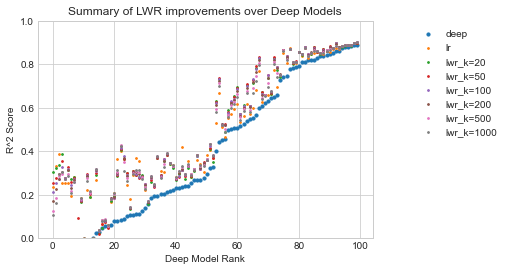

In [11]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
#ax.set_ylim(0,600)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
ax.set_ylim(0,1)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")